# Understanding Autoencoders


## Dataset Source

- [Kaggle]()

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import math
import os
import random
import torch
from torch import nn
import numpy as np
from torchvision import transforms

In [ ]:
!bash dataset_fetch.sh

+ '[' '!' -d dataset ']'
+ echo 'Dataset Directory already exist!'
Dataset Directory already exist!


In [5]:
# Helper Cell


def helper_imageGrid(image_paths, cols=4):
    img_count = len(image_paths)
    rows = math.ceil(img_count / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    irow, icol = 0, 0
    for path in image_paths:
        ax = axes[irow][icol]
        ax.imshow(Image.open(path))
        title = path.split("/")[-2]
        #ax.title(path)
        ax.axis("off")

        icol += 1
        if icol % cols == 0:
            icol = 0
            irow += 1

        
    
    return fig




In [6]:


image_paths = [ f"dataset/GAID/Soul/{x}" for x in os.listdir("dataset/GAID/Soul") ]


sizes = set()
for x in image_paths:
    img = Image.open(x)
    sizes.add(img.size)
    img.close()

print("Sizes of Images: ", sizes)
print("Count of Images: ", len(image_paths))




Sizes of Images:  {(300, 300)}
Count of Images:  1000


In [72]:

'''

100x100 --> 10x10 --> 10 --> 10x10 --> 100x100

'''

device = "cuda" if torch.cuda.is_available() else "cpu"

class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(100**2, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 100**2),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))





def ReconstructionLoss(reproduced, original): 
    return torch.sum((original - reproduced)**2) / len(original)

print(f"{device} is Available!!")


cuda is Available!!


In [4]:


def todata(path):
    image = Image.open(path).convert("L").resize((100, 100))
    tensor = transforms.ToTensor()(image)
    tensor = nn.Flatten(0)(tensor)
    image.close()
    return tensor
    
def toimg(data):
    data = nn.Sigmoid()(data.view(100, 100)) * 255
    return np.uint8(data.detach().numpy())
    

In [104]:
import matplotlib.pyplot as plt
import time
%matplotlib tk


fig = plt.figure()

raw_img = fig.add_axes([0, 0.5, 0.5 - 0.02, 0.5 - 0.02])
trans_img = fig.add_axes([0.5, 0.5, 0.5 - 0.02, 0.5 - 0.02])

loss_ax = fig.add_axes([0, 0, 1 - 0.02, 0.5 - 0.02])

raw_img.axis("off")
trans_img.axis("off")
loss_ax.axis("off")


fig.show()





auto = Autoencoder().to(device)
epochs = 100
loss_ax.set_xlim(left=0, right=epochs)
optimizer = torch.optim.Adam(auto.parameters(),lr=0.001)
for epoch in range(epochs):

    sample_path = random.choice(image_paths)
    sample_data = todata(sample_path)
    sample_img = toimg(sample_data)

    raw_img.imshow(sample_img, cmap="ocean_r")
    timg = toimg(auto(sample_data.to(device)).to("cpu"))
    trans_img.imshow(timg, cmap="ocean_r")
    


    for path in image_paths:
        optimizer.zero_grad()
        sample = todata(path).to(device)
        op = auto(sample).to(device)
        loss = ReconstructionLoss(sample, op)
        loss.backward()

        optimizer.step()

    loss_ax.plot(epoch, loss.to("cpu").item(), "ro")
    fig.canvas.flush_events()
    fig.show()
    print(f"{epoch} done, {loss.to("cpu").item()}")


0 done, 0.14841559529304504
1 done, 0.14826402068138123
2 done, 0.14816395938396454
3 done, 0.148131862282753
4 done, 0.1481492668390274
5 done, 0.14819326996803284
6 done, 0.14821873605251312
7 done, 0.1482449471950531
8 done, 0.1482478380203247
9 done, 0.14827775955200195
10 done, 0.1483001410961151
11 done, 0.148325115442276
12 done, 0.1483718752861023
13 done, 0.14841651916503906
14 done, 0.14851954579353333
15 done, 0.14854498207569122
16 done, 0.14855173230171204
17 done, 0.1485612839460373
18 done, 0.14857639372348785
19 done, 0.14859981834888458
20 done, 0.14864295721054077
21 done, 0.1486753225326538
22 done, 0.1487424075603485
23 done, 0.14877045154571533
24 done, 0.14881503582000732
25 done, 0.14885954558849335
26 done, 0.1488863080739975
27 done, 0.14893145859241486
28 done, 0.14895978569984436
29 done, 0.14900510013103485
30 done, 0.14903172850608826
31 done, 0.1490781158208847
32 done, 0.14910602569580078
33 done, 0.14914889633655548
34 done, 0.14917905628681183
35 done, 

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


invalid command name "124763950186048idle_draw"
    while executing
"124763950186048idle_draw"
    ("after" script)


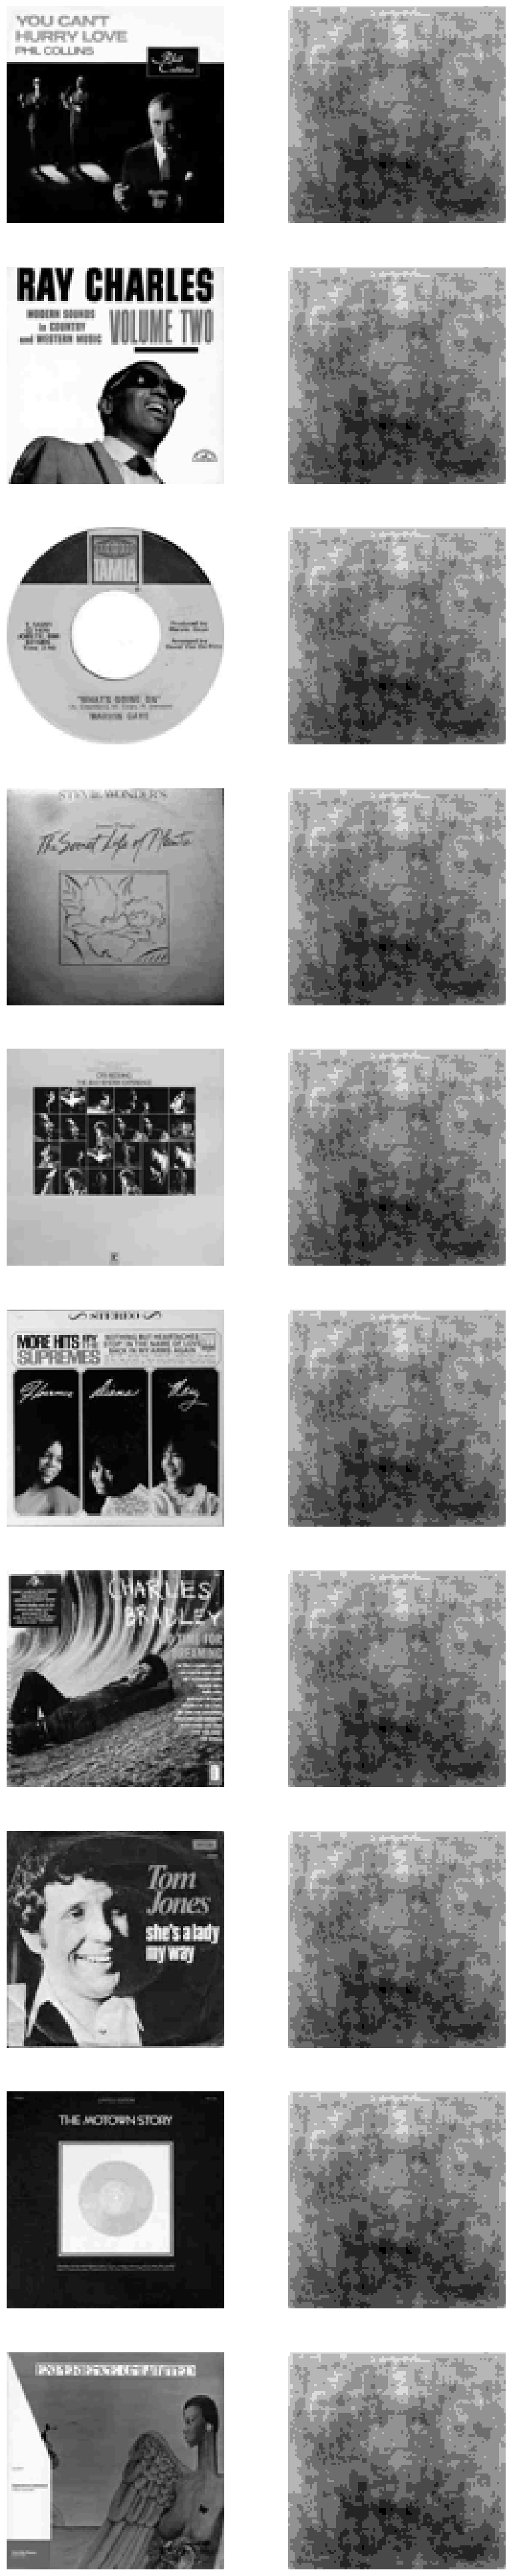

In [9]:
show_count = 10

fig, axes = plt.subplots(show_count, 2, figsize=(10, show_count * 5))

for i, path in enumerate(image_paths[:show_count]):
    data = todata(path).to(device)
    infer = auto(data).to("cpu")
    data = data.to("cpu")
    axes[i][0].imshow(toimg(data), cmap="gray")
    axes[i][0].axis("off")
    axes[i][1].imshow(toimg(infer), cmap="gray")
    axes[i][1].axis("off")

# Understanding and creating a Convolutional Autoencoer

In [10]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(in_channels=5, out_channels=5, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(1)
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (5, 3, 3)),
            nn.UpsamplingBilinear2d(None, (3, 3)),
            nn.ConvTranspose2d(in_channels=5, out_channels=5, kernel_size=3),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(None, (3, 3)),
            nn.ConvTranspose2d(in_channels=5, out_channels=10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(None, (3, 3)),
            nn.ConvTranspose2d(in_channels=10, out_channels=1, kernel_size=3, padding=1),
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))


In [68]:
def prepareTensor(path):
    img = Image.open(path).resize((99, 99)).convert("L")
    data = transforms.ToTensor()(img)
    img.close()
    return data


def toimg(data):
   return np.uint8(data.view(99, 99).detach().numpy() * 255)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CoverArtsDataset(Dataset):
    def __init__(self):
        self.paths = image_paths

    def __getitem__(self, index):
        return prepareTensor(self.paths[index])

    def __len__(self):
        return len(self.paths)
    
device = "cuda" if torch.cuda.is_available() else "cpu"



In [73]:
%matplotlib tk


fig = plt.figure()

raw_img = fig.add_axes([0, 0.5, 0.5 - 0.02, 0.5 - 0.02])
trans_img = fig.add_axes([0.5, 0.5, 0.5 - 0.02, 0.5 - 0.02])

loss_ax = fig.add_axes([0, 0, 1 - 0.02, 0.5 - 0.02])

raw_img.axis("off")
trans_img.axis("off")
loss_ax.axis("off")



fig.show()


print(f"Using Device: {device}")
auto = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(auto.parameters(), lr=0.001)
NUM_EPOCHS = 1000
BATCH_SIZE = 40
loss_ax.set_xlim(left=0, right=NUM_EPOCHS)
dataset = CoverArtsDataset()
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(NUM_EPOCHS):
    
    sample_path = random.choice(image_paths)
    sample_data = prepareTensor(sample_path).unsqueeze(1)
    sample = auto(sample_data.to(device))

    
    img = toimg(sample.to("cpu"))

    raw_img.imshow(np.uint8((sample_data.view(99, 99) * 255).detach().numpy()))
    trans_img.imshow(img)



    optimizer.zero_grad()
    for data in dataloader:
        reconstructed = auto(data.to(device)).to(device)
        original = data.to(device)
        loss = criterion(reconstructed, original).to(device)
        loss.backward()
        optimizer.step()
    
    loss_ax.plot(epoch, loss.to("cpu").item(), "ro--")
    fig.show()
    fig.canvas.flush_events()
    
    
    print(f"Number Of Epoch Done: {epoch}/{NUM_EPOCHS}")
    
torch.save(auto.state_dict(), f"autoencoder_{epoch}")




Using Device: cuda
Number Of Epoch Done: 0/1000
Number Of Epoch Done: 1/1000
Number Of Epoch Done: 2/1000
Number Of Epoch Done: 3/1000
Number Of Epoch Done: 4/1000
Number Of Epoch Done: 5/1000
Number Of Epoch Done: 6/1000
Number Of Epoch Done: 7/1000
Number Of Epoch Done: 8/1000
Number Of Epoch Done: 9/1000
Number Of Epoch Done: 10/1000
Number Of Epoch Done: 11/1000
Number Of Epoch Done: 12/1000
Number Of Epoch Done: 13/1000
Number Of Epoch Done: 14/1000
Number Of Epoch Done: 15/1000
Number Of Epoch Done: 16/1000
Number Of Epoch Done: 17/1000
Number Of Epoch Done: 18/1000
Number Of Epoch Done: 19/1000
Number Of Epoch Done: 20/1000
Number Of Epoch Done: 21/1000
Number Of Epoch Done: 22/1000
Number Of Epoch Done: 23/1000
Number Of Epoch Done: 24/1000
Number Of Epoch Done: 25/1000
Number Of Epoch Done: 26/1000
Number Of Epoch Done: 27/1000
Number Of Epoch Done: 28/1000
Number Of Epoch Done: 29/1000
Number Of Epoch Done: 30/1000
Number Of Epoch Done: 31/1000
Number Of Epoch Done: 32/1000
N

Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.12/tkinter/__init__.py", line 1971, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/tkinter/__init__.py", line 865, in callit
    func(*args)
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/backends/_backend_tk.py", line 271, in idle_draw
    self.draw()
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/backends/backend_tkagg.py", line 10, in draw
    super().draw()
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/backends/backend_agg.py", line 387, in draw
    self.figure.draw(self.renderer)
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/artist.py", line 95, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/someone/.local/lib/python3.12/site-packages/matplotlib/artist.py", line 72, in

Number Of Epoch Done: 835/1000
Number Of Epoch Done: 836/1000
Number Of Epoch Done: 837/1000


KeyboardInterrupt: 

In [93]:
import re


def get_model_state_dict():
    max_name = None
    max_num = 0
    for x in os.listdir():
        if a := re.match("autoencoder_\\d+", x):
            name = a.group()
            num = int(name.split(-1))
            max_num = num if max_num < num else max_num
    if max_num > 0:
        return torch.load(f"autoencoder_{max_num}")
            
        
    



autoencoder_838
